In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
# from pipeline.utils import read_json, make_folder
from PrepareData import read_json

In [87]:
res_path = 'intermediate/models/'
# data_name = 'lsac'
seed = 1
datasets = ['cardio']
# datasets = ['meps16', 'lsac', 'bank', 'cardio', 'ACSM', 'ACSP', 'credit', 'ACSE', 'ACSH', 'ACSI']
vio_cols = ['vio_G0_L0', 'vio_G0_L1', 'vio_G1_L0', 'vio_G1_L1']
# model_name = 'lr'
for data_name in datasets:
    cur_dir = res_path + data_name + '/'
    
#     te_df = pd.read_csv('{}test-cc-{}.csv'.format(cur_dir, seed))
    tr_df = pd.read_csv('{}train-cc-{}.csv'.format(cur_dir, seed))
#     par_dict = read_json('{}par-cc-{}.json'.format(cur_dir, seed))
#     par_dict = read_json('{}par-{}-{}.json'.format(cur_dir, model_name, seed))
    print(data_name)
#     print(par_dict)
    for col_i in vio_cols:
#         print(col_i, te_df[col_i].mean(), sum(te_df[col_i] > 0), te_df.shape[0], te_df.shape[0])
        print(col_i, tr_df[col_i].mean(), sum(tr_df[col_i] > 0), tr_df.shape[0], int(tr_df.shape[0]*0.3))
    
#     meta_info = read_json('{}{}.json'.format('data/processed/', data_name))
#     n_cond_features = len(meta_info['continuous_features'])
#     num_cols = ['X{}'.format(i) for i in range(1, n_cond_features + 1)]
# #     tr_df.head()
    
#     for col_i in num_cols:
#         print(tr_df[col_i].unique(), sum(tr_df[col_i] > 0), tr_df.shape[0])
    print('--'*10,'\n\n')

cardio
vio_G0_L0 0.4713317683714174 41720 49000 14700
vio_G0_L1 0.31378422247066495 36697 49000 14700
vio_G1_L0 0.42992256001984475 40095 49000 14700
vio_G1_L1 0.27875358578991377 33840 49000 14700
-------------------- 




In [86]:
tr_df[['A', 'Y', 'X1']].groupby(by=['A', 'Y']).count()

X1
A Y       
0 0   3678
  1    679
1 0  14959
  1   2025

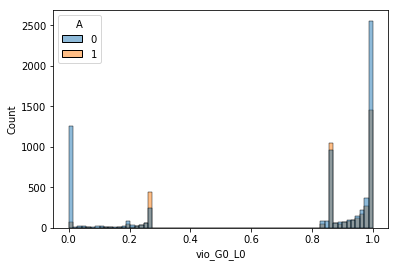

In [80]:
sns.histplot(x='vio_G0_L0', data=tr_df, hue='A')

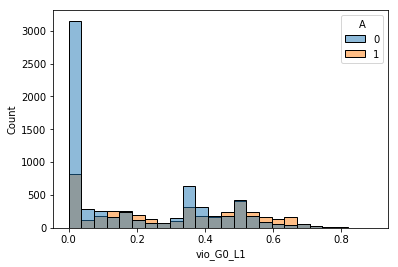

In [81]:
sns.histplot(x='vio_G0_L1', data=tr_df, hue='A')

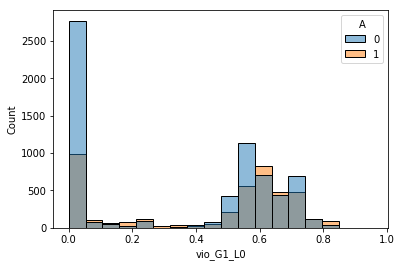

In [82]:
sns.histplot(x='vio_G1_L0', data=tr_df, hue='A')

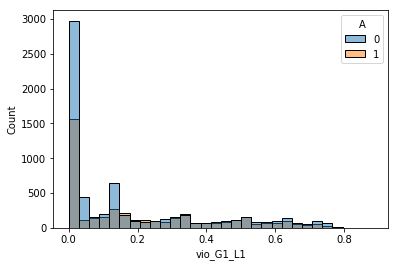

In [83]:
sns.histplot(x='vio_G1_L1', data=tr_df, hue='A')

In [13]:
for col_i in range(1, 7):
    print(tr_df['X{}'.format(col_i)].unique(), sum(tr_df['X{}'.format(col_i)] > 0), tr_df.shape[0])

[3. 2. 4. 1. 0.] 19229 19230
[4. 3. 2. 0. 1.] 19067 19230
[4. 3. 2. 0. 1.] 19174 19230
[3. 2. 4. 1. 0.] 19183 19230
[3. 4. 0. 2. 1.] 19106 19230
[3. 4. 0. 2. 1.] 18965 19230


In [7]:
raw_df = pd.read_csv('data/processed/{}.csv'.format(data_name))
raw_df.head()

,X1,X2,X3,X4,X5,X6,Y,A
0,0.766127,2,0.802982,9120.0,13,0,1,1
1,0.957151,0,0.121876,2600.0,4,0,0,1
2,0.658180,1,0.085113,3042.0,2,1,0,1
3,0.233810,0,0.036050,3300.0,5,0,0,0
4,0.907239,1,0.024926,63588.0,7,0,0,1


In [10]:
for col_i in range(1, 7):
    print(len(raw_df['X{}'.format(col_i)].unique()), sum(raw_df['X{}'.format(col_i)] > 0))

103063 112398
16 20299
109658 117778
13594 118635
58 119113
19 6725


In [9]:
raw_df.shape[0]

120269

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
class Learner(object):
    # code from "https://github.com/schelterlabs/learning-to-validate-predictions/blob/master/pp/learners.py"
    def __init__(self, scoring):
        self.scoring = scoring

    def split(self, data, seed, sizes=[0.7, 0.5]):
        np.random.seed(seed)
        n = data.shape[0]
        split_point = int(sizes[0] * n)
        order = list(np.random.permutation(n))
        train_data = data.iloc[order[:split_point], :]

        vt_data = data.iloc[order[split_point:], :]
        second_n = vt_data.shape[0]
        second_order = list(np.random.permutation(second_n))
        second_split_point = int(sizes[1] * second_n)

        val_data = vt_data.iloc[second_order[:second_split_point], :]
        test_data = vt_data.iloc[second_order[second_split_point:], :]
        return train_data, val_data, test_data

    def scoring_name(self):
        return self.scoring

    def score(self, y_true, y_pred):
        if self.scoring == 'accuracy':
            return accuracy_score(y_true, y_pred)

        if self.scoring == 'roc_auc':
            return roc_auc_score(y_true, y_pred)

        if self.scoring == 'neg_mean_squared_error':
            return mean_squared_error(y_true, y_pred)

        raise Exception('unknown scoring {}'.format(self.scoring))
class SKLogisticRegression(Learner):

    def __init__(self, scoring='accuracy'):
        super(SKLogisticRegression, self).__init__(scoring)
        self.name = "LR"

    def fit(self, train_data, train_Y, transform_cols, sample_weight=None):

        param_grid = {
            'learner__loss': ['log'],
            'learner__penalty': ['l2', 'l1', 'elasticnet'],
            'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
        }

        feature_transformation = ColumnTransformer(transformers=[
            ('scaled_numeric', StandardScaler(), transform_cols),
        ])

        pipeline = Pipeline([
            ('features', feature_transformation),
            ('learner', SGDClassifier(max_iter=1000))])

        search = GridSearchCV(pipeline, param_grid, scoring=self.scoring, cv=5, verbose=-1, n_jobs=-1)

        if sample_weight is not None:
            model = search.fit(train_data, train_Y, **{'learner__sample_weight': sample_weight})
        else:
            model = search.fit(train_data, train_Y)

        return model

In [5]:
def generate_model_predictions(data_name, cur_model, cur_data, opt_thres=None):
    if data_name in ['adult', 'german', 'compas']:
        pos_ind = np.where(cur_model.classes_ == 1.0)[0][0] # default positive label is 1.0
        Y_pred_proba = cur_model.predict_proba(cur_data)[:, pos_ind].reshape(-1, 1)
    elif data_name in ['cardio', 'bank', 'lawgpa', 'meps16', 'credit', 'UFRGS']:
        pos_ind = np.where(cur_model.best_estimator_.named_steps['learner'].classes_ == 1.0)[0][0]
        Y_pred_proba = cur_model.predict_proba(cur_data)[:, pos_ind].reshape(-1, 1)
    else:
        raise ValueError('The input dataset is not supported!. Choose from [adult, german, compas, cardio, bank, meps16, lawgpa, credit, UFRGS]')
    if opt_thres is not None:
        return [int(y > opt_thres) for y in Y_pred_proba]
    else:
        return Y_pred_proba

In [16]:
datasets = ['cardio', 'bank', 'meps16', 'lsac', 'credit', 'ACSE', 'ACSP', 'ACSH', 'ACST', 'ACSM', 'ACSI']
for name in datasets:
    df = pd.read_csv('data/processed/'+name+'.csv')
    print(name, len(df['Y'].unique()))

cardio 2
bank 2
meps16 2
lsac 2
credit 2
ACSE 2
ACSP 2
ACSH 2
ACST 2
ACSM 2
ACSI 2


In [7]:
df['Y'].value_counts()

0    54766
1    45234
Name: Y, dtype: int64

In [8]:
df[['Y', 'A', 'X1']].groupby(by=['A', 'Y']).count()

X1
A Y       
0 0   4560
  1   2763
1 0  50206
  1  42471

In [67]:
df = pd.read_csv('data/cardio/cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [64]:
df = pd.read_csv('data/processed/cardio_dense.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,Y,C0
0,-0.917571,-0.122181,-0.088238,0,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0
1,1.210072,0.072610,-0.035180,1,0,0,0,1,1,0,0,1,0,1,0,0,1,1,1
2,-0.664647,0.007679,-0.141296,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0
3,0.189439,0.137540,0.017878,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,0
4,-0.746175,-0.187111,-0.194354,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0


In [6]:
df.shape

(1000, 12)

In [7]:
features = list(set(df.columns).difference(['credit']))
train_x = df[features]
train_y = np.array(df['credit'])

In [8]:
def compute_weight_kam(train_df, sensi_col, y_col, n_groups=2, n_labels=2):
    weight = {}
    total_n = train_df.shape[0]
    for group_i in range(n_groups):
        n_g = train_df[train_df[sensi_col] == group_i].shape[0]

        for label_i in range(n_labels):
            n_label = train_df[train_df[y_col] == label_i].shape[0]

            cc_train = train_df[(train_df[sensi_col] == group_i) & (train_df[y_col] == label_i)] #.copy()

#             prop_weight_base = n_label * n_g / (total_n * cc_train.shape[0])
            weight[str(group_i) + '_' + str(label_i)] = n_label * n_g / (total_n * cc_train.shape[0])
    return weight

In [48]:
df['age'].value_counts()

1.0    810
0.0    190
Name: age, dtype: int64

In [52]:
df.shape[0] / 810

1.2345679012345678

In [53]:
df.shape[0] / 190

5.2631578947368425

In [44]:
train_x

,credit_history=Other,age,savings=Unknown/None,credit_history=Delay,employment=4+ years,savings=<500,sex,employment=1-4 years,savings=500+,employment=Unemployed,credit_history=None/Paid
0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
996,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
997,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
998,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [25]:
def compute_weight_sp(X_train, y_train, sensitive_attr, lam):
    group_1_y_1 = np.array(X_train[sensitive_attr] == 1).astype(int) * np.array(y_train==1).astype(int)
    group_1_y_0 = np.array(X_train[sensitive_attr] == 1).astype(int) * np.array(y_train==0).astype(int)
    group_0_y_1 = np.array(X_train[sensitive_attr] == 0).astype(int) * np.array(y_train==1).astype(int)
    group_0_y_0 = np.array(X_train[sensitive_attr] == 0).astype(int) * np.array(y_train==0).astype(int)
    group_1 = np.array(X_train[sensitive_attr] == 1).astype(int)
    group_0 = np.array(X_train[sensitive_attr] == 0).astype(int)
    print(np.sum(group_1))
    sample_weights = np.ones(y_train.shape)
#     if sensitive_attr=='C0':
    sample_weights -= lam * X_train.shape[0] / np.sum(group_1) * group_1_y_1 - lam * X_train.shape[0] / np.sum(group_1) * group_1_y_0 \
                    - lam * X_train.shape[0] / np.sum(group_0) * group_0_y_1 + lam * X_train.shape[0] / np.sum(group_0) * group_0_y_0
#     else:
#         sample_weights += lam * X_train.shape[0] / np.sum(group_1) * group_1_y_1 - lam * X_train.shape[0] / np.sum(group_1) * group_1_y_0 \
#                         - lam * X_train.shape[0] / np.sum(group_0) * group_0_y_1 + lam * X_train.shape[0] / np.sum(group_0) * group_0_y_0
    return sample_weights

In [26]:
up_weights = compute_weight_sp(train_x, train_y, 'age', 1.0)
up_weights[:13]

810


array([-0.2345679 , -4.26315789, -0.2345679 , -0.2345679 ,  2.2345679 ,
       -0.2345679 , -0.2345679 , -0.2345679 , -0.2345679 ,  2.2345679 ,
       -4.26315789, -4.26315789,  6.26315789])

In [46]:
def compute_weight_kam_np(df, y_col, sensi_col):
    group_1_y_1 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 1).astype(int)
    group_1_y_0 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 0).astype(int)
    group_0_y_1 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 1).astype(int)
    group_0_y_0 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 0).astype(int)
    group_1 = np.array(df[sensi_col] == 1).astype(int)
    group_0 = np.array(df[sensi_col] == 0).astype(int)
    target_1 = np.array(df[y_col] == 1).astype(int)
    target_0 = np.array(df[y_col] == 0).astype(int)
    
    total_n = df.shape[0]
#     print(total_n)
#     print((np.sum(group_1) * np.sum(target_1) / (total_n * np.sum(group_1_y_1))))
    
    sample_weights = np.zeros(total_n)
    
    sample_weights += group_1_y_1 * (np.sum(group_1) * np.sum(target_1) / (total_n * np.sum(group_1_y_1))) \
                     + group_1_y_0 * (np.sum(group_1) * np.sum(target_0) / (total_n * np.sum(group_1_y_0))) \
                     + group_0_y_1 * (np.sum(group_0) * np.sum(target_1) / (total_n * np.sum(group_0_y_1))) \
                     + group_0_y_0 * (np.sum(group_0) * np.sum(target_0) / (total_n * np.sum(group_0_y_0)))
                    
    return sample_weights

In [47]:
up_weights = compute_weight_kam_np(df, 'credit', 'age')
up_weights[:13]

array([0.96101695, 0.7125    , 0.96101695, 0.96101695, 1.10454545,
       0.96101695, 0.96101695, 0.96101695, 0.96101695, 1.10454545,
       0.7125    , 0.7125    , 1.20909091])

In [61]:
def compute_weight_singlecc(df, y_col, sensi_col, cc_col, alpha_group_0, alpha_group_1, sample_base='kam', lam=1.0):
    
    group_1_y_1 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 1).astype(int)
    group_1_y_0 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 0).astype(int)
    group_0_y_1 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 1).astype(int)
    group_0_y_0 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 0).astype(int)
    group_1 = np.array(df[sensi_col] == 1).astype(int)
    group_0 = np.array(df[sensi_col] == 0).astype(int)
    target_1 = np.array(df[y_col] == 1).astype(int)
    target_0 = np.array(df[y_col] == 0).astype(int)
    
    group_1_y_1_vio_0 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 1).astype(int) * np.array(df[cc_col] == 0).astype(int)
    
    group_1_y_0_vio_0 = np.array(df[sensi_col] == 1).astype(int) * np.array(df[y_col] == 0).astype(int) * np.array(df[cc_col] == 0).astype(int)
    
    group_0_y_1_vio_0 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 1).astype(int) * np.array(df[cc_col] == 0).astype(int)
    
    group_0_y_0_vio_0 = np.array(df[sensi_col] == 0).astype(int) * np.array(df[y_col] == 0).astype(int) * np.array(df[cc_col] == 0).astype(int)
    
    
    total_n = df.shape[0]
#     print(total_n)
#     print((np.sum(group_1) * np.sum(target_1) / (total_n * np.sum(group_1_y_1))))
    
    if sample_base == 'kam':
        sample_weights = np.zeros(total_n)

        sample_weights += group_1_y_1 * (np.sum(group_1) * np.sum(target_1) / (total_n * np.sum(group_1_y_1))) \
                         + group_1_y_0 * (np.sum(group_1) * np.sum(target_0) / (total_n * np.sum(group_1_y_0))) \
                         + group_0_y_1 * (np.sum(group_0) * np.sum(target_1) / (total_n * np.sum(group_0_y_1))) \
                         + group_0_y_0 * (np.sum(group_0) * np.sum(target_0) / (total_n * np.sum(group_0_y_0)))
    elif sample_base == 'omn':
        sample_weights = np.ones(total_n)
        sample_weights -= lam * total_n / np.sum(group_1) * group_1_y_1 \
                        - lam * total_n / np.sum(group_1) * group_1_y_0 \
                        - lam * total_n / np.sum(group_0) * group_0_y_1 \
                        + lam * total_n / np.sum(group_0) * group_0_y_0
    
    elif sample_base == 'zero':
        sample_weights = np.zeros(total_n)
    else:
        raise ValueError('The input base parameter is not supported. Choose from "[kam, omn, zero]".')
    
    # single cc 
    sample_weights -= alpha_group_1 * group_1_y_1_vio_0 \
                    - alpha_group_1 * group_1_y_0_vio_0 \
                    - alpha_group_0 * group_0_y_1_vio_0 \
                    + alpha_group_0 * group_0_y_0_vio_0
    
    return sample_weights

In [52]:
df['vio_cc'] = [0, 0, 1, 1, 0, 0, 1, 1, 1, 1] + [0 for i in range(990)]

In [62]:
up_weights = compute_weight_singlecc(df, 'credit', 'age', 'vio_cc', 5.0, 2.0, sample_base='omn')
up_weights[:13]

array([-2.2345679 , -9.26315789, -0.2345679 , -0.2345679 ,  4.2345679 ,
       -2.2345679 , -0.2345679 , -0.2345679 , -0.2345679 ,  2.2345679 ,
       -9.26315789, -9.26315789, 11.26315789])

In [56]:
cc_res = [-2., -5.,  0.,  0.,  2., -2.,  0.,  0.,  0.,  0., -5., -5.,  5.]
kam_res = [0.96101695, 0.7125    , 0.96101695, 0.96101695, 1.10454545,
       0.96101695, 0.96101695, 0.96101695, 0.96101695, 1.10454545,
       0.7125    , 0.7125    , 1.20909091]

In [59]:
mix = [x + y for x, y in zip(kam_res, cc_res)]
mix

[-1.0389830500000001,
 -4.2875,
 0.96101695,
 0.96101695,
 3.10454545,
 -1.0389830500000001,
 0.96101695,
 0.96101695,
 0.96101695,
 1.10454545,
 -4.2875,
 -4.2875,
 6.2090909100000005]

In [36]:
kam_weights = compute_weight_kam(df, 'age', 'credit')

In [37]:
kam_weights

{'0_0': 0.7125,
 '0_1': 1.209090909090909,
 '1_0': 1.1045454545454545,
 '1_1': 0.9610169491525423}

In [42]:
df.head(15)

,age,sex,credit_history=Delay,credit_history=None/Paid,credit_history=Other,savings=500+,savings=<500,savings=Unknown/None,employment=1-4 years,employment=4+ years,employment=Unemployed,credit
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
6,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
7,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
8,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
9,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [22]:
df = pd.read_csv('data/processed/UFRGS_features.csv')
seed = 1
y_col = 'Y'

learner = SKLogisticRegression()

train_df, validate_df, test_df = learner.split(df, seed)

features = [x for x in train_df.columns if x != y_col]

train_data = train_df[features]
Y_train = np.array(train_df[y_col])


val_data = validate_df[features]
Y_val = np.array(validate_df[y_col])

test_data = test_df[features]
Y_test = np.array(test_df[y_col])

model = learner.fit(train_data, Y_train, features)

# # for optimal threshold selection
# validate_df['Y'] = Y_val
# validate_df['Y_pred_scores'] = generate_model_predictions(data_name, model, val_data)

test_df['Y'] = Y_test
test_df['Y_pred_scores'] = generate_model_predictions(data_name, model, test_data, opt_thres=0.5)

In [23]:
test_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y,C0,Y_pred_scores
31949,0.388155,-0.021885,-0.977524,1.023077,0.402453,1.523510,0.681574,0.792142,0.167501,0,0,1
36855,-0.702391,-1.229354,0.767325,-1.205139,2.561402,1.683796,-0.088480,-0.514943,-0.438453,1,0,1
16867,-1.119053,-0.412546,0.047903,-1.314034,0.583706,0.675895,-0.642469,-1.367469,-1.588489,1,1,0
34430,-0.580988,0.018038,-0.291430,0.786408,-0.853096,0.898725,-0.521298,-1.447691,-0.113768,0,0,1
11610,-1.343102,0.850422,-0.834340,-0.403616,0.586681,-0.531585,-0.033861,-0.772436,-1.219319,1,0,1


In [25]:
eval_settings(test_df, 'C0', 'Y_pred_scores')

{'G0': {'AUC': 0.611,
  'ACC': 0.628,
  'ERR': 0.372,
  'FPR': 0.526706231454006,
  'FNR': 0.2508690614136732,
  'PR': 0.5614834092387768,
  'TPR': 0.7491309385863267,
  'TNR': 0.4732937685459941,
  'TP': 1293.0,
  'FN': 433.0,
  'TN': 638.0,
  'FP': 710.0,
  'SR': 0.6515940143135979,
  'BalAcc': 0.6112123535661604},
 'G1': {'AUC': 0.637,
  'ACC': 0.693,
  'ERR': 0.30700000000000005,
  'FPR': 0.13851193261581657,
  'FNR': 0.5867704280155642,
  'PR': 0.3755113968439509,
  'TPR': 0.4132295719844358,
  'TNR': 0.8614880673841835,
  'TP': 531.0,
  'FN': 754.0,
  'TN': 1841.0,
  'FP': 296.0,
  'SR': 0.24167153711279954,
  'BalAcc': 0.6373588196843096},
 'all': {'AUC': 0.659,
  'ACC': 0.662,
  'ERR': 0.33799999999999997,
  'FPR': 0.2886657101865136,
  'FNR': 0.39422118897376285,
  'PR': 0.46351600985221675,
  'TPR': 0.6057788110262371,
  'TNR': 0.7113342898134863,
  'TP': 1824.0,
  'FN': 1187.0,
  'TN': 2479.0,
  'FP': 1006.0,
  'SR': 0.4356527093596059,
  'BalAcc': 0.6585565504198617,
  'DI'

In [26]:
(638 + 710) / (638 +710 + 1293 +433)

0.4385165907612232

In [27]:
(1841 + 296) / (1841 +296 + 531 +754)

0.6244886031560491

In [28]:
df = pd.read_csv('data/processed/UFRGS_features.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y,C0
0,0.403613,-0.760029,-1.495491,1.538432,0.982352,-0.282166,1.839695,1.326399,-0.551941,0,0
1,-0.331060,-0.769690,-1.849364,-0.517347,-0.465138,-1.464779,-0.269203,-1.744422,-0.740582,0,1
2,-1.050275,-1.268292,-0.105789,-1.800956,-1.332838,-1.694714,-0.865304,-0.898872,-1.467067,0,1
3,1.569971,1.093808,-0.525895,0.110933,-0.441558,-0.666359,0.474688,1.783748,0.147531,0,0
4,0.073097,0.800246,0.600790,0.403661,1.057387,-0.731163,0.246461,0.017919,-0.380416,0,1


In [32]:
df['C0'] = df['C0'].apply(lambda x: int(x!=1))
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y,C0
0,0.403613,-0.760029,-1.495491,1.538432,0.982352,-0.282166,1.839695,1.326399,-0.551941,0,1
1,-0.331060,-0.769690,-1.849364,-0.517347,-0.465138,-1.464779,-0.269203,-1.744422,-0.740582,0,0
2,-1.050275,-1.268292,-0.105789,-1.800956,-1.332838,-1.694714,-0.865304,-0.898872,-1.467067,0,0
3,1.569971,1.093808,-0.525895,0.110933,-0.441558,-0.666359,0.474688,1.783748,0.147531,0,1
4,0.073097,0.800246,0.600790,0.403661,1.057387,-0.731163,0.246461,0.017919,-0.380416,0,0


In [33]:
df.to_csv('data/processed/UFRGS_dense_opp.csv', index=False)

In [31]:
df = pd.read_csv('data/processed/UFRGS_dense.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y,C0
0,0.403613,-0.760029,-1.495491,1.538432,0.982352,-0.282166,1.839695,1.326399,-0.551941,0,0
1,-0.331060,-0.769690,-1.849364,-0.517347,-0.465138,-1.464779,-0.269203,-1.744422,-0.740582,0,1
2,-1.050275,-1.268292,-0.105789,-1.800956,-1.332838,-1.694714,-0.865304,-0.898872,-1.467067,0,1
3,1.569971,1.093808,-0.525895,0.110933,-0.441558,-0.666359,0.474688,1.783748,0.147531,0,0
4,0.073097,0.800246,0.600790,0.403661,1.057387,-0.731163,0.246461,0.017919,-0.380416,0,1


In [34]:
# extracting results from MultiCC and multi-model
exp_suffix = 'orig'
exp_setting = 'Single_eval'

res_path = 'intermediate/models/'

data_name = 'UFRGS'
seed = 1

test_vio = pd.read_csv(res_path+data_name + '/' + '-'.join(['test_eval_single', str(seed), 'SingleCC']) + '.csv')

test_vio.head()

,C0,Y,Y_pred,Y_pred_cc
0,1,0,1,1
1,1,1,1,1
2,0,1,0,0
3,1,0,1,0
4,1,1,0,0


In [35]:
test_eval = read_json(res_path+data_name + '/' + '-'.join(['Single_eval', str(seed), 'SingleCC']))


In [16]:
(1003 + 345) / (1003+345+870+856)

0.4385165907612232

In [17]:
(1735+402) / (1735+402+597+688)

0.6244886031560491

In [36]:
test_eval

{'A': {'G0': {'AUC': 0.638,
   'ACC': 0.681,
   'ERR': 0.31899999999999995,
   'FPR': 0.1881141787552644,
   'FNR': 0.535408560311284,
   'PR': 0.3755113968439509,
   'TPR': 0.46459143968871597,
   'TNR': 0.8118858212447356,
   'TP': 597.0,
   'FN': 688.0,
   'TN': 1735.0,
   'FP': 402.0,
   'SR': 0.2919345412039743,
   'BalAcc': 0.6382386304667258},
  'G1': {'AUC': 0.624,
   'ACC': 0.609,
   'ERR': 0.391,
   'FPR': 0.2559347181008902,
   'FNR': 0.4959443800695249,
   'PR': 0.5614834092387768,
   'TPR': 0.5040556199304751,
   'TNR': 0.7440652818991098,
   'TP': 870.0,
   'FN': 856.0,
   'TN': 1003.0,
   'FP': 345.0,
   'SR': 0.3952504879635654,
   'BalAcc': 0.6240604509147925},
  'all': {'AUC': 0.636,
   'ACC': 0.647,
   'ERR': 0.353,
   'FPR': 0.21434720229555237,
   'FNR': 0.5127864496844902,
   'PR': 0.46351600985221675,
   'TPR': 0.4872135503155098,
   'TNR': 0.7856527977044476,
   'TP': 1467.0,
   'FN': 1544.0,
   'TN': 2738.0,
   'FP': 747.0,
   'SR': 0.34082512315270935,
   'Bal

In [5]:
test_vio[['C0', 'Y', 'Y_pred']].groupby(by=['C0', 'Y_pred']).count()

Y
C0 Y_pred      
0  0       1859
   1       1215
1  0       2423
   1        999

In [6]:
test_vio[['C0', 'Y', 'Y_pred']].groupby(by=['C0', 'Y']).count()

Y_pred
C0 Y        
0  0    1348
   1    1726
1  0    2137
   1    1285

In [7]:
999 / (1215+999)

0.45121951219512196

In [8]:
1285 / (1285 + 1726)

0.4267685154433743

In [17]:
# extracting results from MultiCC and multi-model
exp_suffix = 'error0.15'
exp_setting = 'Single_eval'

res_path = 'intermediate/models/'

data_name = 'adult'
seed = 1

test_vio_err = pd.read_csv(res_path+data_name + '/' + '-'.join(['test_eval_single', str(seed), exp_suffix]) + '.csv')

test_vio_err.head()

,sex,Y,Y_pred
0,0.0,0.0,0
1,1.0,0.0,1
2,0.0,0.0,0
3,1.0,1.0,1
4,0.0,0.0,0


In [18]:
# extracting results from MultiCC and multi-model
exp_suffix = 'orig'
exp_setting = 'Single_eval'

res_path = 'intermediate/models/'

data_name = 'adult'
seed = 1

test_vio = pd.read_csv(res_path+data_name + '/' + '-'.join(['test_eval_single', str(seed), 'SingleCC']) + '.csv')

test_vio.head()

,sex,Y,Y_pred,Y_pred_cc
0,1.0,0.0,0,0
1,1.0,0.0,1,1
2,0.0,0.0,0,0
3,1.0,1.0,1,1
4,0.0,0.0,0,0


In [21]:
sum(list(test_vio['Y_pred_cc'] != test_vio_err['Y_pred']))

0

In [12]:
for col in ['Y', 'Y_pred', 'Y_pred_G0', 'Y_pred_G1', 'Y_pred_en', 'Y_pred_en_cc']:
    print(col, sum(list(test_vio[col] != test_vio_err[col])))
    

Y 0
Y_pred 0
Y_pred_G0 0
Y_pred_G1 0
Y_pred_en 93
Y_pred_en_cc 0


In [22]:
# extracting results from MultiCC and multi-model

res_path = '/Users/keyang/Projects/Local/DiffExplain/intermediate/models/'

data_name = 'adult'
seed = 6

test_vio_old = pd.read_csv(res_path+data_name + '/' + '-'.join(['test_eval_drift', str(seed)]) + '.csv')

test_vio_old.head()

,sex,Y,Y_pred,Y_pred_G0,Y_pred_G1,Y_pred_en,Y_pred_en_cc
0,1,0,0,0,0,0,0.0
1,0,0,1,1,1,1,1.0
2,1,0,1,1,1,1,1.0
3,1,1,1,1,1,1,1.0
4,1,0,0,0,0,0,0.0


In [25]:
# extracting results from MultiCC and multi-model

res_path = '/Users/keyang/Projects/Local/DiffExplain/intermediate/models/'

data_name = 'lawgpa'
seed = 6

test_cc_old = pd.read_csv(res_path+data_name + '/' + '-'.join(['test_eval_fair', str(seed), 'cc']) + '.csv')

test_cc_old.head()

,sex,Y,Y_pred,Y_pred_cc
0,1.0,0.0,0,0
1,0.0,0.0,1,1
2,1.0,0.0,1,1
3,1.0,1.0,1,1
4,1.0,0.0,0,0


In [23]:
sum(list(test_vio['Y'] != test_vio_old['Y']))

0

In [24]:
for col in ['Y', 'Y_pred', 'Y_pred_G0', 'Y_pred_G1', 'Y_pred_en', 'Y_pred_en_cc']:
    print(col, sum(list(test_vio[col] != test_vio_old[col])), sum(list(test_vio_old[col] != test_cc_old[col])))
    

Y 0
Y_pred 0
Y_pred_G0 0
Y_pred_G1 0
Y_pred_en 0
Y_pred_en_cc 0


In [27]:
for col in ['Y', 'Y_pred']:
    print(col, sum(list(test_vio_old[col] != test_cc_old[col])))
    

Y 0
Y_pred 0


In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_absolute_error

def eval_predictions(y_true, y_pred, label_order=[0, 1], metrics=['AUC', 'ACC', 'ERR', 'FPR', 'FNR', 'PR', 'TPR', 'TNR', 'TP', 'FN', 'TN', 'FP', 'SR']):
    if metrics == 'MAE':
        return mean_absolute_error(y_true, y_pred)
    else:
        ACC = round(accuracy_score(y_true, y_pred), 3)
        try:
            AUC = round(roc_auc_score(y_true, y_pred), 3)
        except Exception:
            AUC = -1

        TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel() #, labels=label_order
        pred_P = TP+FP
        # pred_N = TN+FN
        P = TP + FN
        N = TN + FP
        eval_dict = dict(
                    PR = P/ (P+N) if (P+N) > 0.0 else np.float64(0.0),
                    P = np.float64(P), N = np.float64(N), FP = np.float64(FP), TP = np.float64(TP), FN = np.float64(FN), TN = np.float64(TN),
                    TPR=TP / P if P > 0.0 else np.float64(0.0),
                    TNR=TN / N if N > 0.0 else np.float64(0.0),
                    FPR=FP / N if N > 0.0 else np.float64(0.0),
                    FNR=FN / P if P > 0.0 else np.float64(0.0),
                    PPV=TP / (TP+FP) if (TP+FP) > 0.0 else np.float64(0.0),
                    NPV=TN / (TN+FN) if (TN+FN) > 0.0 else np.float64(0.0),
                    FDR=FP / (FP+TP) if (FP+TP) > 0.0 else np.float64(0.0),
                    FOR=FN / (FN+TN) if (FN+TN) > 0.0 else np.float64(0.0),
                    ACC=ACC,
                    AUC=AUC if AUC != -1 else np.float64(0.0),
                    ERR=1-ACC,
                    F1=2*TP / (2*TP+FP+FN) if (2*TP+FP+FN) > 0.0 else np.float64(0.0),
                    SR= pred_P / len(y_pred)
                )
        return {key:eval_dict[key] for key in metrics}
def eval_settings(test_eval_df, sensi_col, pred_col, n_groups=2):

    results = {}
    PR_all = []
    TPR_all = []
    FPR_all = []

    for group_i in range(n_groups):
        group_df = test_eval_df[test_eval_df[sensi_col] == group_i]
        eval_res = eval_predictions(group_df['Y'], group_df[pred_col])
        bal_acc = 0.5 * (eval_res['TPR'] + eval_res['TNR'])
        eval_res.update({'BalAcc': bal_acc})
        results['G'+str(group_i)] = eval_res

        PR_all.append(eval_res['SR'])
        TPR_all.append(eval_res['TPR'])
        FPR_all.append(eval_res['FPR'])

    eval_res_all = eval_predictions(test_eval_df['Y'], test_eval_df[pred_col])
    bal_acc_all = 0.5 * (eval_res_all['TPR'] + eval_res_all['TNR'])
    # additional overall fairness measures
    di_pr = PR_all[0] / PR_all[1] if PR_all[1] > 0 else 0
    eq = TPR_all[0] - TPR_all[1]
    avg_odds = 0.5 * (FPR_all[0] - FPR_all[1] + eq)
    sp_diff = PR_all[0] - PR_all[1]
    for metric_i, value_i in zip(['BalAcc', 'DI', 'EQDiff', 'AvgOddsDiff', 'SPDiff'], [bal_acc_all, di_pr, eq, avg_odds, sp_diff]):
        eval_res_all.update({metric_i: value_i})
    results['all'] = eval_res_all
    return results

In [33]:
eval_settings(test_vio, 'sex', 'Y_pred')

{'G0': {'AUC': 0.716,
  'ACC': 0.644,
  'ERR': 0.356,
  'FPR': 0.37643810400368155,
  'FNR': 0.19117647058823528,
  'PR': 0.11124744376278119,
  'TPR': 0.8088235294117647,
  'TNR': 0.6235618959963185,
  'TP': 220.0,
  'FN': 52.0,
  'TN': 1355.0,
  'FP': 818.0,
  'SR': 0.4245398773006135,
  'BalAcc': 0.7161927127040416},
 'G1': {'AUC': 0.714,
  'ACC': 0.684,
  'ERR': 0.31599999999999995,
  'FPR': 0.3652872878832986,
  'FNR': 0.20682862770847013,
  'PR': 0.31196231052847195,
  'TPR': 0.7931713722915299,
  'TNR': 0.6347127121167014,
  'TP': 1208.0,
  'FN': 315.0,
  'TN': 2132.0,
  'FP': 1227.0,
  'SR': 0.49877099549365017,
  'BalAcc': 0.7139420422041156},
 'all': {'AUC': 0.713,
  'ACC': 0.671,
  'ERR': 0.32899999999999996,
  'FPR': 0.36966738973246566,
  'FNR': 0.20445682451253483,
  'PR': 0.24498430462672308,
  'TPR': 0.7955431754874652,
  'TNR': 0.6303326102675344,
  'TP': 1428.0,
  'FN': 367.0,
  'TN': 3487.0,
  'FP': 2045.0,
  'SR': 0.4740002729630135,
  'BalAcc': 0.7129378928774999,


In [35]:
eval_settings(test_vio, 'sex', 'Y_pred')

{'G0': {'AUC': 0.716,
  'ACC': 0.644,
  'ERR': 0.356,
  'FPR': 0.37643810400368155,
  'FNR': 0.19117647058823528,
  'PR': 0.11124744376278119,
  'TPR': 0.8088235294117647,
  'TNR': 0.6235618959963185,
  'TP': 220.0,
  'FN': 52.0,
  'TN': 1355.0,
  'FP': 818.0,
  'SR': 0.4245398773006135,
  'BalAcc': 0.7161927127040416},
 'G1': {'AUC': 0.714,
  'ACC': 0.684,
  'ERR': 0.31599999999999995,
  'FPR': 0.3652872878832986,
  'FNR': 0.20682862770847013,
  'PR': 0.31196231052847195,
  'TPR': 0.7931713722915299,
  'TNR': 0.6347127121167014,
  'TP': 1208.0,
  'FN': 315.0,
  'TN': 2132.0,
  'FP': 1227.0,
  'SR': 0.49877099549365017,
  'BalAcc': 0.7139420422041156},
 'all': {'AUC': 0.713,
  'ACC': 0.671,
  'ERR': 0.32899999999999996,
  'FPR': 0.36966738973246566,
  'FNR': 0.20445682451253483,
  'PR': 0.24498430462672308,
  'TPR': 0.7955431754874652,
  'TNR': 0.6303326102675344,
  'TP': 1428.0,
  'FN': 367.0,
  'TN': 3487.0,
  'FP': 2045.0,
  'SR': 0.4740002729630135,
  'BalAcc': 0.7129378928774999,


In [7]:
# extracting results from MultiCC and multi-model
exp_suffix = 'orig'
exp_setting = 'Multi_eval'

res_path = 'intermediate/models/'
group_eval_metrics = ['AUC', 'ACC', 'SR', 'BalAcc']
overall_metrics = ['BalAcc', 'DI', 'EQDiff', 'AvgOddsDiff', 'SPDiff']
settings = ['A', 'E', 'F']


data_name = 'adult'
seed = 6

eval_res = read_json(res_path+data_name+'/'+'-'.join([exp_setting, str(seed), exp_suffix]))
for setting in settings:
    for group in ['all', 'G0', 'G1']:
        base = [data_name, seed, setting, group]
        for metric_i in group_eval_metrics:
            print(base, metric_i, eval_res[setting][group][metric_i])
    for metric_i in overall_metrics:
        print(data_name, seed, setting, 'all', metric_i, eval_res[setting]['all'][metric_i])
    print('\n\n')

['adult', 6, 'A', 'all'] AUC 0.713
['adult', 6, 'A', 'all'] ACC 0.671
['adult', 6, 'A', 'all'] SR 0.4740002729630135
['adult', 6, 'A', 'all'] BalAcc 0.7129378928774999
['adult', 6, 'A', 'G0'] AUC 0.716
['adult', 6, 'A', 'G0'] ACC 0.644
['adult', 6, 'A', 'G0'] SR 0.4245398773006135
['adult', 6, 'A', 'G0'] BalAcc 0.7161927127040416
['adult', 6, 'A', 'G1'] AUC 0.714
['adult', 6, 'A', 'G1'] ACC 0.684
['adult', 6, 'A', 'G1'] SR 0.49877099549365017
['adult', 6, 'A', 'G1'] BalAcc 0.7139420422041156
adult 6 A all BalAcc 0.7129378928774999
adult 6 A all DI 0.8511719429082525
adult 6 A all EQDiff 0.015652157120234822
adult 6 A all AvgOddsDiff 0.013401486620308878
adult 6 A all SPDiff -0.07423111819303668



['adult', 6, 'E', 'all'] AUC 0.716
['adult', 6, 'E', 'all'] ACC 0.676
['adult', 6, 'E', 'all'] SR 0.46976934625358263
['adult', 6, 'E', 'all'] BalAcc 0.7164776423623909
['adult', 6, 'E', 'G0'] AUC 0.721
['adult', 6, 'E', 'G0'] ACC 0.658
['adult', 6, 'E', 'G0'] SR 0.40899795501022496
['adult',